**КЛАСТЕРИЗАЦИЯ ПОКУПАТЕЛЕЙ**

В этом проекте попробуем разделить покупателей по покумаемым продуктам. Мы имеем набор данных продаж продуктов оптовой базы. Продажи осуществляются по таким категориям:
*    **Fresh** - свежие продукты (фрукты, овощи...);
*    **Milk** - молочная продукция;
*    **Grocery** - бакалея (мука, крупа...);
*    **Frozen** - замороженые продукты (мясо, рыба...);
*    **Detergents_Paper** - моющие средства и бумага;
*    **Delicatessen** - деликатесы.

Для работы я часто использую GoogleColaboratory, так у меня очень старый компьютер.

Загружаем данные в Colab

In [4]:
# ----------------------------------------------
#           ***  MOUNT DRIVE  ***
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/Mount.txt', 'r') as file:
    print(file.read())
# ==============================================

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mount successful!


Импортируем необходимые библиотеки и фреймворки

In [5]:
# ----------------------------------------------
#         ***  IMPORTS PROJECT  ***
from os import listdir, mkdir 
from os.path import isfile, join, exists
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
sns.set(style='whitegrid') 
# ==============================================

Загружаем набор данных

In [6]:
# ----------------------------------------------
#            ***  DIRECTORY  ***
base_dir = '/content/drive/My Drive/'
dataset_dir = join(base_dir, 'Datasets', 'customer_data')

file_path = join(dataset_dir, 'customers.csv')
# ==============================================

In [7]:
df = pd.read_csv(file_path)
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Набор данных имеет ненужные нам колонки "Region" и "Channel". Удаляем их

In [8]:
df.drop(['Region', 'Channel'], axis = 1, inplace = True)

Проверим, есть ли в нашем наборе данных нули, пропуски или дубликаты. Как мы видем их нет

In [9]:
df.isnull().sum()

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [10]:
df.isna().sum()

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [11]:
df.loc[df.duplicated()].sum()

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Наш набор данных имеет 440 строк и 6 категорий

In [12]:
df.shape

(440, 6)

In [13]:
head_list = list(df.columns)
print(head_list)

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


Построим распределение наших данных

Text(0.5, 1.0, 'Распределения данных')

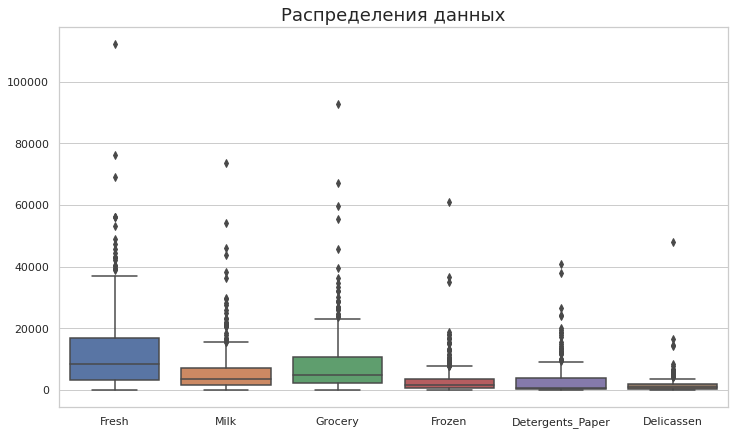

In [14]:
sns.boxplot(data=df)
plt.title('Распределения данных', fontsize=18)

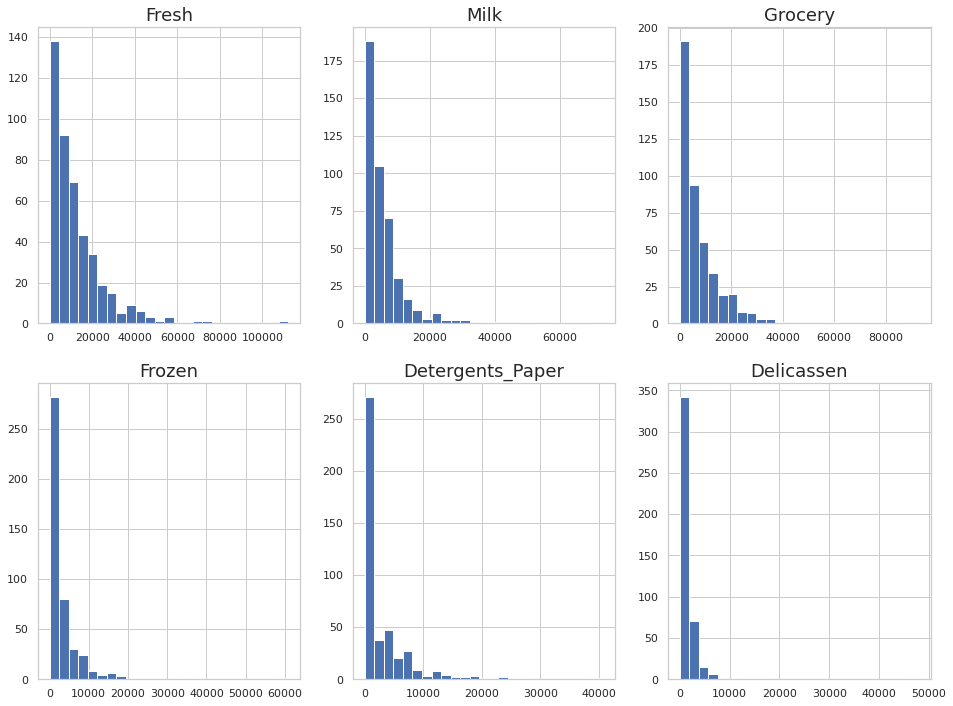

In [15]:
if True:
    plt.figure(figsize=(16, 12))
    plt.subplot(2,3,1)
    plt.hist(df['Fresh'], bins=25)
    plt.title('Fresh', fontsize=18)
    plt.subplot(2,3,2)
    plt.hist(df['Milk'], bins=25)
    plt.title('Milk', fontsize=18)
    plt.subplot(2,3,3)
    plt.hist(df['Grocery'], bins=25)
    plt.title('Grocery', fontsize=18)
    plt.subplot(2,3,4)
    plt.hist(df['Frozen'], bins=25)
    plt.title('Frozen', fontsize=18)
    plt.subplot(2,3,5)
    plt.hist(df['Detergents_Paper'], bins=25)
    plt.title('Detergents_Paper', fontsize=18)
    plt.subplot(2,3,6)
    plt.hist(df['Delicassen'], bins=25)
    plt.title('Delicassen', fontsize=18)

Как можно заметить графики распределений типичные для сферы продаж. Очень много покупок на небольшую сумму, график прижат к оси y и тянется по оси х. Также распределения имеют много выбросов, и среднее значение находится далеко от медианы.

In [16]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Попытаемся определить насколько связаны покупки между собой. Будем предсказывать по текущем покупкам что клиент может купить ещё. Например, если покупатель купил замороженые продукты и молочные, значит он купит и деликатесы. Для этого посмотрим на точечные диаграмы категорий. И будем поочередно обучать модель линейной регресси на всех категориях без одной проверочной.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e37546860>,
      dtype=object)

<Figure size 1152x864 with 0 Axes>

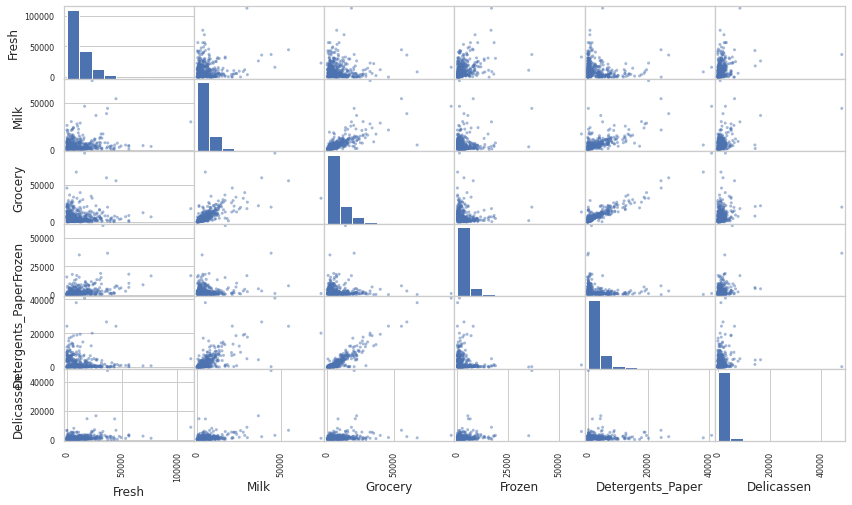

In [17]:
from pandas.plotting import scatter_matrix
plt.figure(figsize=(16,12))
scatter_matrix(df, figsize=(14, 8))

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae

score = []

for i in range(len(head_list)):
    new_data = df.drop([head_list[i]], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(
        new_data, df[head_list[i]], test_size = 0.25, random_state=42)

    model = LinearRegression().fit(x_train,y_train)
    pred = model.predict(x_test)
    mae_score = mae(y_test, pred)
    r2_score = r2(y_test, pred)
    score.append([head_list[i], mae_score, r2_score])

score_df = pd.DataFrame(score, columns=['Name', 'MAE', 'R2'])
score_df

,Name,MAE,R2
0,Fresh,9148.566410,0.147620
1,Milk,2247.257461,0.606414
2,Grocery,2214.121351,0.770648
3,Frozen,2478.316199,0.170628
4,Detergents_Paper,1094.475923,0.702213
5,Delicassen,1049.635549,-0.145786


Из полученых результатов можно сказать, что наиболее зависимые категории от других: 

*    бакалея;
*    моющие средства; 
*    молочные изделия.

Так как данные не распределены нормально, особенно если среднее значение и медиана значительно отличаются (что указывает на большой перекос), наиболее часто целесообразно применять нелинейное масштабирование. Простой подход, который может работать в большинстве случаев - это применение натурального логарифма.

In [19]:
log_df = df.apply(lambda x: np.log(x))
log_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


In [20]:
log_df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


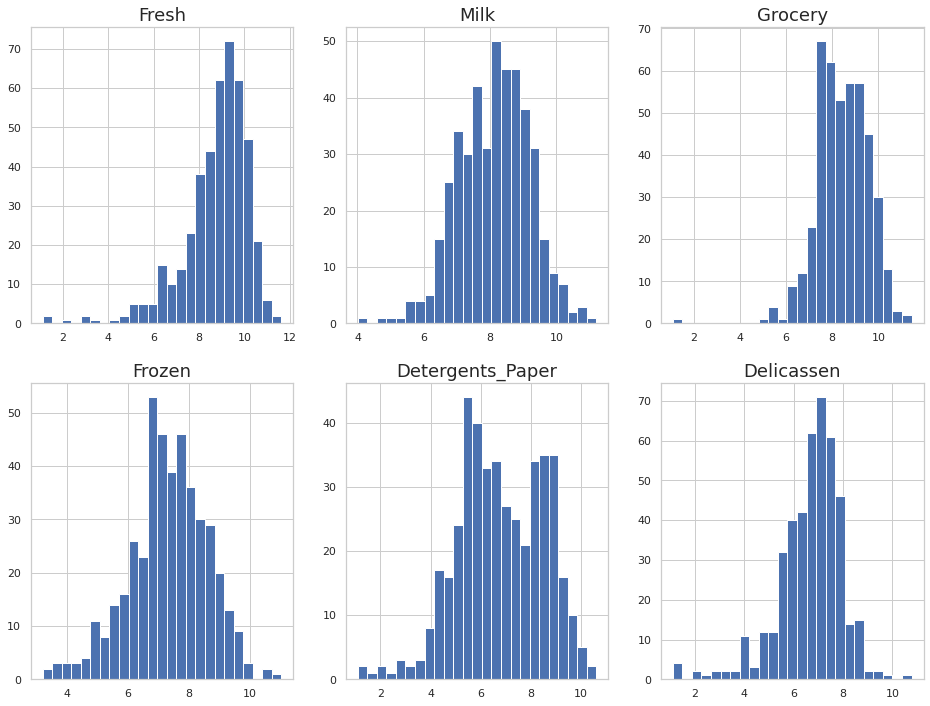

In [21]:
if True:
    plt.figure(figsize=(16, 12))
    plt.subplot(2,3,1)
    plt.hist(log_df['Fresh'], bins=25)
    plt.title('Fresh', fontsize=18)
    plt.subplot(2,3,2)
    plt.hist(log_df['Milk'], bins=25)
    plt.title('Milk', fontsize=18)
    plt.subplot(2,3,3)
    plt.hist(log_df['Grocery'], bins=25)
    plt.title('Grocery', fontsize=18)
    plt.subplot(2,3,4)
    plt.hist(log_df['Frozen'], bins=25)
    plt.title('Frozen', fontsize=18)
    plt.subplot(2,3,5)
    plt.hist(log_df['Detergents_Paper'], bins=25)
    plt.title('Detergents_Paper', fontsize=18)
    plt.subplot(2,3,6)
    plt.hist(log_df['Delicassen'], bins=25)
    plt.title('Delicassen', fontsize=18)

Теперь, после применения натурального логарифма к данным, распределения каждых категорий выглядят более ближе к нормальным. И разница между средним значением и медианой существенно сократилась

Посмотрим на связь категорий между собой после масштабирования. Для этого построим диаграмму рассеяния и корреллционную матрицу.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e36f664a8>,
      dtype=object)

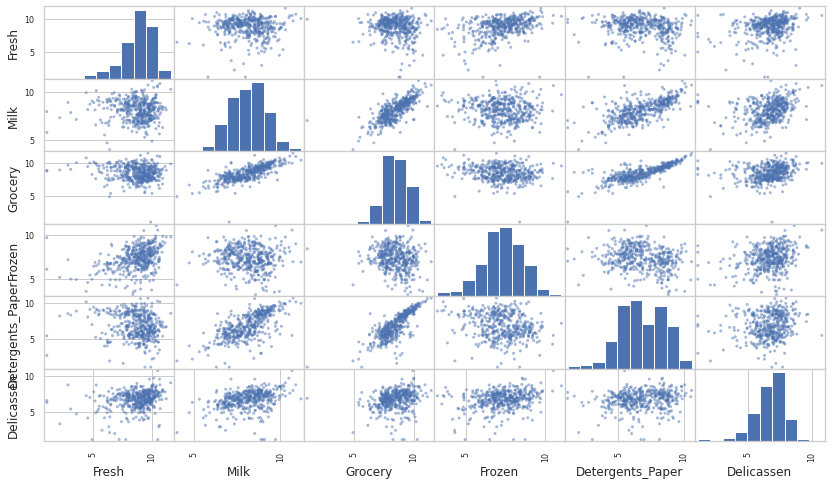

In [22]:
scatter_matrix(log_df, figsize=(14, 8))

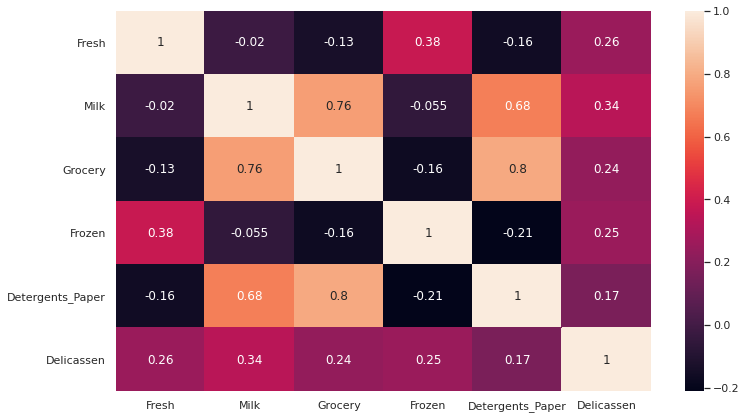

In [23]:
corrmatrix = log_df.corr()
sns.heatmap(corrmatrix, annot=True)
plt.show()

Обнаружение выбросов в данных чрезвычайно важно на этапе предварительной обработки любого анализа. Наличие выбросов часто может исказить результаты. Чтобы избавиться от выбросов мы  рассчитываем диапазон нормальных значений. Для этого мы берём IQR. Это диапазон между нижним и верхним квартилем (50% всего распределения). Левая граница рассчитывается как нижний квартиль минус полтора IQR, а правая – верхний квартиль плюс полтора IQR. Всё что выходит за эти границы считается выбросом.

In [24]:
outliers  = []

for feature in log_df.keys():
    
    # расчитываем нижний и верхний квартили
    Q1 = np.percentile(log_df[feature],25)
    Q3 = np.percentile(log_df[feature],75)
    step = (Q3-Q1) * 1.5
    
    # проверяем какие признаци выходят за пределы 
    out = log_df[~((log_df[feature] >= Q1 - step) & (log_df[feature] <= Q3 + step))]
    display(out)
    outliers = outliers + list(out.index.values)
    
# создаём список выбросов, которые повтояются больше одного раза
# потому что выбросов очень много и мы не можем их все удалить
outliers = list(set([x for x in outliers if outliers.count(x) > 1]))    

print("Выбросы: {}".format(outliers))

# убираем эти выбросы из данных
data = log_df.drop(log_df.index[outliers]).reset_index(drop = True)
data.shape

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Выбросы: [128, 65, 66, 75, 154]


(435, 6)

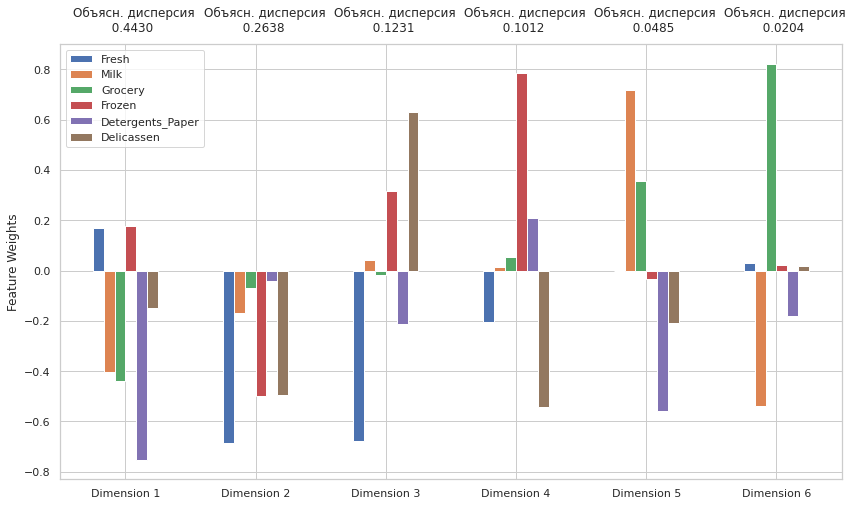

In [25]:
from sklearn.decomposition import PCA

# используем метод главных компонент для снижения размерности
pca = PCA().fit(data)

# количество измерений
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# главные компоненты
components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys())
components.index = dimensions

# расчитываем коэффициент объяснённой дисперсии
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

fig, ax = plt.subplots(figsize = (14,8))
components.plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature Weights")
ax.set_xticklabels(dimensions, rotation=0)
for i, ev in enumerate(pca.explained_variance_ratio_):
    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Объясн. дисперсия\n          %.4f"%(ev))

pca_results = pd.concat([variance_ratios, components], axis = 1)

Как можно заметить, первая и вторая компоненты в сумме объясняют приблизительно 72% дисперсии наших данных. Первые четыре компоненты в общей сложности объясняют приблизительно 93% дисперсии.

При использовании анализа главных компонент одной из основных целей является уменьшение размерности данных - фактически, уменьшение сложности задачи. За снижение размерности приходится платить: меньшее количество используемых измерений означает, что объясняется меньшая общая дисперсия данных. Но мы не можем увидеть шестимерное пространство. Для визуальной проверки полученных кластеров будем использовать две главных компоненты.

In [26]:
# Снижаем размерность данных до двух компонент с помощью PCA
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)

# создаём DataFrame для удобной работы с данными
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

Далее будем использовать разные алгоритмы кластеризации для решения задачи разделения покупателей. 

Заранее мы не знаем количество кластеров. Поэтому воспользуемся алгоритмом DBSCAN, ему не нужно занть количество кластеров

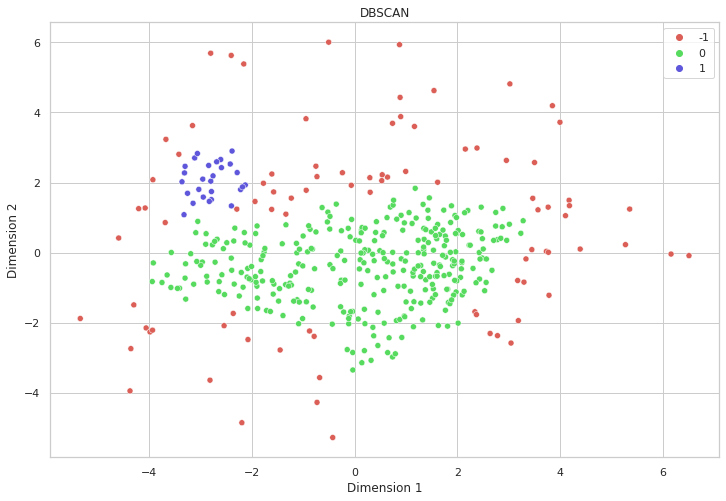

In [27]:
from sklearn.cluster import DBSCAN 

db = DBSCAN(eps=0.5, min_samples=8).fit(reduced_data)

clusters = db.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data['Dimension 1'], y = reduced_data['Dimension 2'], hue=clusters, 
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))
plt.title('DBSCAN')
plt.show()

Как мы видем, DBSCAN не дал нам хорошего результата. Это очень мощный алгоритм, но для данной задачи он не подходит. Принцип работы этого алгоритма основан на плотности точек. Здесь же расположение точек имеет разную плотность, и визуально довольно трудно разделить на кластеры.

Попробуем другой алгоритм MeanShift, которому тоже не нужно знать количество кластеров.

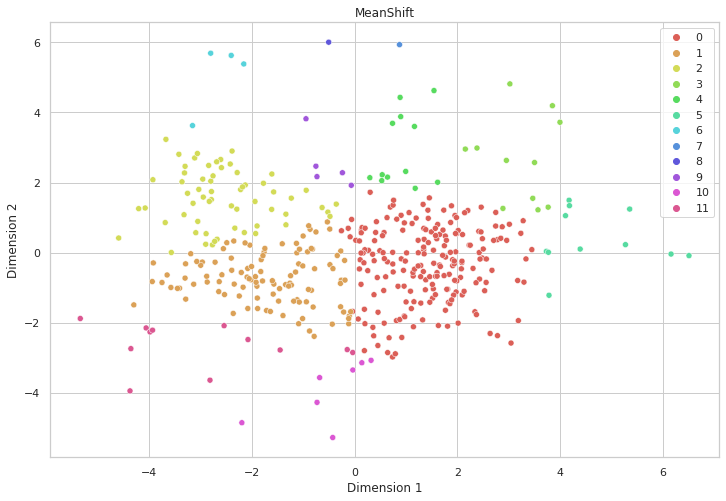

In [28]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(reduced_data, quantile=0.1)
ms = MeanShift(bandwidth).fit(reduced_data)

clusters = ms.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data['Dimension 1'], y = reduced_data['Dimension 2'], hue=clusters, 
                palette=sns.color_palette('hls', np.unique(ms.labels_).shape[0]))
plt.plot()
plt.title('MeanShift')
plt.show()

MeanShift также дал плохой результат. Он разделил данные на 11 кластеров, что очень много. И данное разделение не даёт нам чёткого понимания поведения покупателей.


Визуально изучив график, можно предположительно выделить два нечётких кластера. Попробуем построить их с помощью простого и универсального алгоритма KMeans.

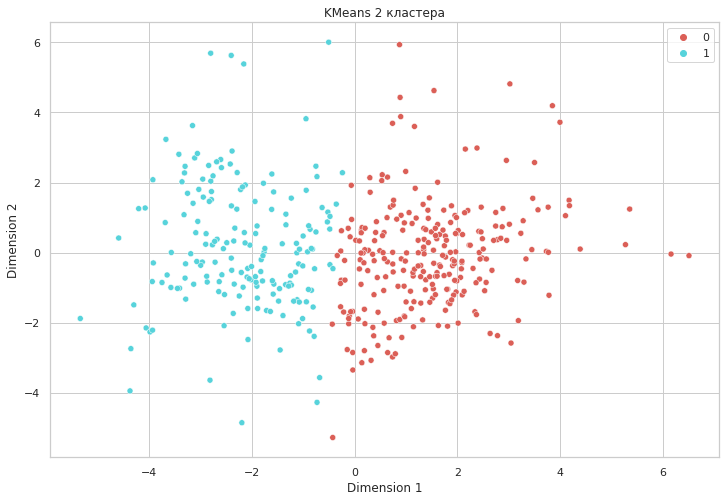

In [29]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2).fit(reduced_data)

clusters = km.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data['Dimension 1'], y = reduced_data['Dimension 2'], hue=clusters, 
                palette=sns.color_palette('hls', 2))
plt.title('KMeans 2 кластера')
plt.show()

Отлично, имеем неплохой разделение, проверим ещё алгоритмом Hierarchical Clustering

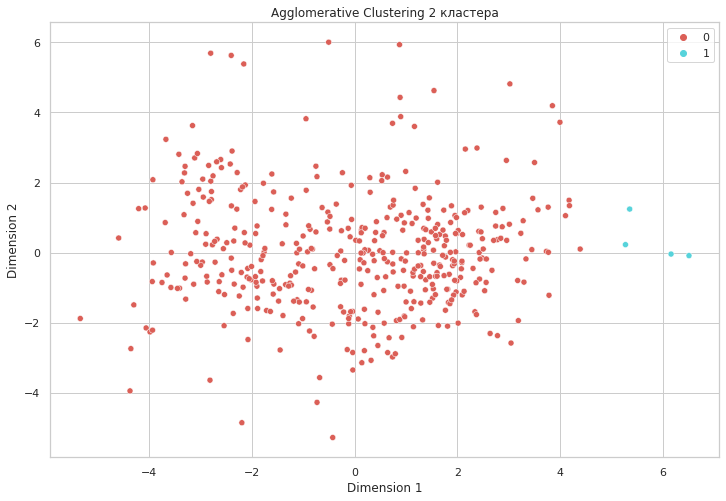

In [30]:
from sklearn.cluster import AgglomerativeClustering 

agglom = AgglomerativeClustering(n_clusters=2, linkage='average').fit(reduced_data)

clusters = agglom.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data['Dimension 1'], y = reduced_data['Dimension 2'], hue=clusters, 
                palette=sns.color_palette('hls', 2))
plt.title('Agglomerative Clustering 2 кластера')
plt.show()

Мы получили очень плохой результат, почти все точки слились в один кластер.

Ещё мы можем воспользоваться алгоритмом Гауссовой смеси. Проверим его.

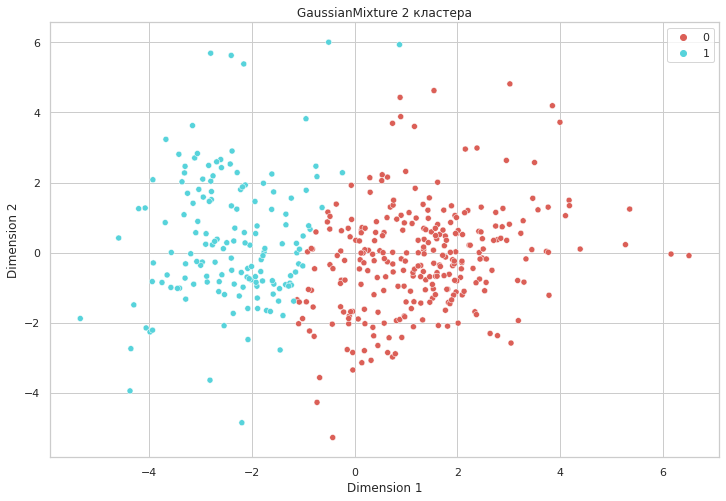

In [31]:
from sklearn.mixture import GaussianMixture

gmix = GaussianMixture(n_components=2).fit(reduced_data)

clusters = gmix.predict(reduced_data)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_data['Dimension 1'], y = reduced_data['Dimension 2'], hue=clusters, 
                palette=sns.color_palette('hls', 2))
plt.title('GaussianMixture 2 кластера')
plt.show()

Тоже имеем не плохой результат разбиения на два кластера. Но визуально видно, что у алгоритма Kmeans лучше получилось разделение.

Проверим это сравнив два алгоритма. Для этого будем использовать коэффициент силуета. И попробуем подобрать оптимальное количество кластеров, которое даст наилучшее разделение.

In [32]:
# KMeans
from sklearn.metrics import silhouette_score

for n in range(2, 10):
    clusterer = KMeans(n_clusters=n).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    score = silhouette_score(reduced_data, preds)    
    print("Коэффициент силуета для {} кластеров: {}".format(n,score))

Коэффициент силуета для 2 кластеров: 0.42628101546910835
Коэффициент силуета для 3 кластеров: 0.3933369810495143
Коэффициент силуета для 4 кластеров: 0.33124591606066633
Коэффициент силуета для 5 кластеров: 0.34999779752629756
Коэффициент силуета для 6 кластеров: 0.36306031734520244
Коэффициент силуета для 7 кластеров: 0.3582392170561094
Коэффициент силуета для 8 кластеров: 0.3652228805193171
Коэффициент силуета для 9 кластеров: 0.3636724086557293


In [33]:
# GaussianMixture
for n in range(2, 10):
    clusterer = GaussianMixture(n_components=n).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    score = silhouette_score(reduced_data,preds)
    print("Коэффициент силуета для {} кластеров: {}".format(n,score))

Коэффициент силуета для 2 кластеров: 0.4223246826459388
Коэффициент силуета для 3 кластеров: 0.37781736386963943
Коэффициент силуета для 4 кластеров: 0.29495285696356033
Коэффициент силуета для 5 кластеров: 0.3036212564312607
Коэффициент силуета для 6 кластеров: 0.27721198743688386
Коэффициент силуета для 7 кластеров: 0.33998626898246964
Коэффициент силуета для 8 кластеров: 0.25883904839086425
Коэффициент силуета для 9 кластеров: 0.30824100080438827


Из полученых результатов можно сделать вывод, что наилучшим алгоритмом для решения текущей задачи разделения покупателей является **KMeans**. И разбиение на **два кластера** будет оптимальным.

**ИСПОЛЬЗОВАНИЕ ПОЛУЧЕННЫХ ДАННЫХ**

Найдём центры полученных кластеров

In [34]:
clusterer = KMeans(n_clusters=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_

Построем график полученых кластеров и укажем их центры

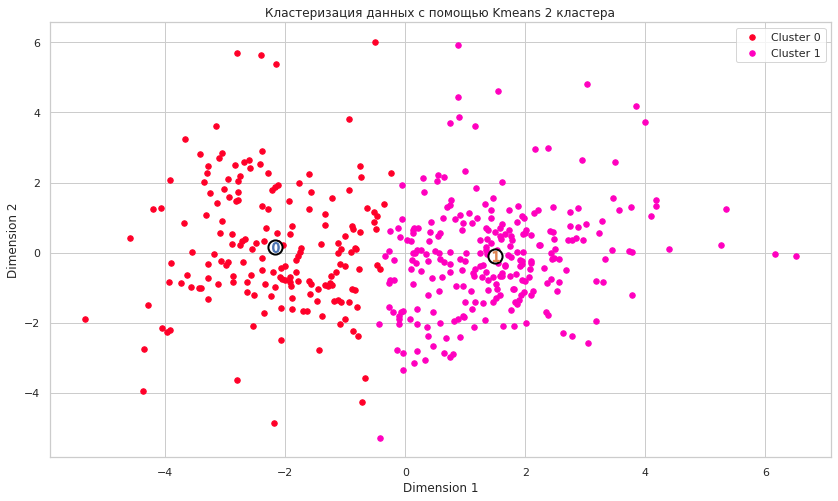

In [35]:
import matplotlib.cm as cm

predictions = pd.DataFrame(preds, columns = ['Cluster'])
plot_data = pd.concat([predictions, reduced_data], axis = 1)

fig, ax = plt.subplots(figsize = (14,8))
cmap = cm.get_cmap('gist_rainbow')

for i, cluster in plot_data.groupby('Cluster'):   
    cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                    color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

for i, c in enumerate(centers):
    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                alpha = 1, linewidth = 2, marker = 'o', s=200);
    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

ax.set_title("Кластеризация данных с помощью Kmeans 2 кластера");

Восстановление данных

In [36]:
# обратным преобразование PCA находим центры кластеров
log_centers = pca.inverse_transform(centers)

# возвращаем данные к первоначальному масштабу
true_centers = np.exp(log_centers)

# высветим затраты по каждой категории в центрах кластеров
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
true_centers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,4005.0,7900.0,12104.0,952.0,4561.0,1036.0
Segment 1,8867.0,1897.0,2477.0,2088.0,294.0,681.0


Тогда на основе данных затрат по центрам кластеров, *можно предположить*:
* **Кластер 0**: этот сегмент лучше всего представляет супермаркеты. Они тратят больше, на *молоко*, *бакалею*, *моющие средства, бумагу* и *деликатесы*, которые необходимы для хранения в таких местах, и их чаще покупают в супермаркетах. 
* **Кластер 1**: этот сегмент лучше всего представляет рестораны. Их расходы на *свежие* и *замороженые продукты* выше. Их расходы на молоко, бакалейные товары и моющие средства  ниже чем в первом сегменте, что дополняет нашу оценку.       

In [37]:
df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Оптовый склад продуктов может использовать полученную информацию для оптимизации своей работы и более индивидуального подхода к клтентам**